<a href="https://colab.research.google.com/github/lorrespz/Transformers-Language-Models--Pytorch-/blob/main/Seq2Seq_LSTM2LSTM_Language_Translation_%5BTensorFlow%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seq2Seq-LSTM-Translation-[TensorFlow]

This code is from Lazy Programmer's NLP3 course.

In [1]:
import os, sys

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import keras.backend as K

In [3]:
# some config
BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 80  # Number of epochs to train for.
LATENT_DIM = 256  # Latent dimensionality of the encoding space.
NUM_SAMPLES = 10000  # Number of samples to train on.
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100



# Dataset: English to Spanish translation

In [4]:
!wget -nc https://lazyprogrammer.me/course_files/nlp3/spa.txt

File ‘spa.txt’ already there; not retrieving.



# Process the dataset to create input, target

In [5]:
# Where we will store the data
input_texts = [] # sentence in original language
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1

t = 0
for line in open('spa.txt'):
  # only keep a limited number of samples
  t += 1
  if t > NUM_SAMPLES:
    break

  # input and target are separated by tab
  if '\t' not in line:
    continue

   # split up the input and translation
  input_text, translation, *rest = line.rstrip().split('\t')

  # make the target input and output
  # recall we'll be using teacher forcing
  target_text = translation + ' <eos>'
  target_text_input = '<sos> ' + translation

  input_texts.append(input_text)
  target_texts.append(target_text)
  target_texts_inputs.append(target_text_input)
print("num samples:", len(input_texts))

num samples: 10000


In [6]:
line

"I'm a little shy.\tSoy un poco tímido.\n"

# Tokenize the inputs and outputs

In [7]:
# tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)
# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

# determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)

Found 2494 unique input tokens.


In [8]:
# tokenize the outputs
# don't filter out special characters
# otherwise <sos> and <eos> won't appear
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

In [9]:
# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)

Found 6378 unique output tokens.


## Pad the sequences

In [10]:
# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])

decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

encoder_inputs.shape: (10000, 6)
encoder_inputs[0]: [ 0  0  0  0  0 18]
decoder_inputs[0]: [   2 2564    0    0    0    0    0    0    0]
decoder_inputs.shape: (10000, 9)


# Load pretrained word vector Glove6B

In [11]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-03-22 05:57:29--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.2’

glove.6B.zip.2      100%[===================>] 822.24M  5.01MB/s    in 2m 39s  

2024-03-22 06:00:09 (5.16 MB/s) - ‘glove.6B.zip.2’ saved [862182613/862182613]

replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.200d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [12]:
# store all the pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [13]:
list(word2vec.keys())[12:20]

['that', 'on', 'is', 'was', 'said', 'with', 'he', 'as']

In [14]:
list(word2vec.items())[12], list(word2vec.values())[12].shape

(('that',
  array([-9.3337e-02,  1.9043e-01,  6.8457e-01, -4.1548e-01, -2.2777e-01,
         -1.1803e-01, -9.5434e-02,  1.9613e-01,  1.7785e-01, -2.0244e-02,
         -5.5409e-02,  3.3867e-01,  7.9396e-01, -4.7126e-02,  4.4281e-01,
         -6.1266e-02,  2.0796e-01,  3.4094e-02, -6.4751e-01,  3.5874e-01,
          1.3936e-01, -6.8310e-01,  2.5596e-01, -1.2911e-01,  2.6080e-01,
         -1.1674e-01,  2.4925e-02, -6.0259e-01, -4.1474e-01, -5.1104e-01,
          1.4936e-01,  7.9977e-01, -1.2716e-01,  4.0474e-01, -2.1435e-01,
          4.7031e-01,  4.9000e-01,  4.8886e-01, -1.7772e-01, -1.8861e-01,
         -7.8391e-01, -1.4158e-01,  2.2169e-01, -2.2078e-01, -3.0509e-01,
         -1.0837e-01,  5.7168e-01, -7.8320e-01, -1.6328e-01, -7.6131e-01,
          8.0873e-02,  6.7217e-04,  4.4713e-01,  1.3434e+00, -2.0014e-01,
         -2.8680e+00, -2.6470e-03, -3.9858e-01,  1.8379e+00,  1.2211e+00,
         -1.6066e-01,  6.5853e-01,  2.6946e-01,  2.7212e-01,  9.4735e-01,
          2.4372e-01,  8.194

In [15]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


# Create the embedding layer

In [16]:
# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input,
  # trainable=True
)


## Define all the layers of the encoder-decoder

The Seq2Seq model has 2 parts: an encoder part (LSTM/GRU-based) and a decoder part (also LSTM/GRU-based architecture).

- The encoder part comprises an embedding layer (with pretrained word vectors like Glove), and an LSTM/GRU layer. The input to the enccoder is the input sequence. Only the hidden state h (and the cell state c) of the encoder will be passed into the decoder GRU (LSTM).

- The decoder part also comprises an embedding layer and a LSTM/GRU layer. The embedding layer of the decoder does not need to have pretrained word vectors (although it's fine to use it). The inputs to the decoder are the hidden (and cell) states of the encoder, and the target input sequence (which is the target sequence but with the token 'sos' at the beginning instead of the token 'eos' at the end).

In [17]:
#GRU VERSION

########## ENCODER ##########
encoder_inputs_placeholder = Input(shape=(max_len_input,))
#embedding layer
x = embedding_layer(encoder_inputs_placeholder)
#gru layer
encoder = GRU(
  LATENT_DIM,
  return_state=True,
)
# Putting all layers together

encoder_outputs, h = encoder(x)
# keep only the states H to pass into decoder
encoder_states = [h] # gru

########### DECODER: DEFINE ALL LAYERS ##########
# Set up the decoder, using [h, c] as initial state.
# this word embedding will not use pre-trained vectors
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
#DECODER-GRU
# since the decoder is a "to-many" model we want to have
# return_sequences=True
decoder_gru = GRU(
  LATENT_DIM,
  return_sequences=True,
  return_state=True,
)
# final dense layer for predictions
decoder_dense = Dense(num_words_output, activation='softmax')

########### DECODER: PUTTING ALL LAYERS TOGETHER ##########
decoder_inputs_placeholder = Input(shape=(max_len_target,))
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)
decoder_outputs, _ = decoder_gru(
   decoder_inputs_x,
   initial_state=encoder_states
 )
decoder_outputs = decoder_dense(decoder_outputs)

# Create the model object
model_gru = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

model_gru.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 6)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 9)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 6, 100)               249500    ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 9, 100)               637900    ['input_2[0][0]']             
                                                                                              

In [18]:
#LSTM VERSION
########## ENCODER ##########
encoder_inputs_placeholder = Input(shape=(max_len_input,))
#Define the layers
x = embedding_layer(encoder_inputs_placeholder)
#lstm layer
encoder = LSTM(
  LATENT_DIM,
  return_state=True,
)
#Putting the layers together

encoder_outputs, h, c = encoder(x)
# keep only the states to pass into decoder
encoder_states = [h, c]

########### DECODER ##########
# Set up the decoder, using [h, c] as initial state.
# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
# since the decoder is a "to-many" model we want to have
# return_sequences=True
decoder_lstm = LSTM(
  LATENT_DIM,
  return_sequences=True,
  return_state=True,
  # dropout=0.5 # dropout not available on gpu
)
# final dense layer for predictions
decoder_dense = Dense(num_words_output, activation='softmax')

########### DECODER: PUTTING LAYERS TOGETHER ##########
decoder_inputs_placeholder = Input(shape=(max_len_target,))
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)
decoder_outputs, _, _ = decoder_lstm(
  decoder_inputs_x,
  initial_state=encoder_states
)
decoder_outputs = decoder_dense(decoder_outputs)

# Create the model object
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 6)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 9)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 6, 100)               249500    ['input_3[0][0]']             
                                                                                                  
 embedding_2 (Embedding)     (None, 9, 100)               637900    ['input_4[0][0]']             
                                                                                            

In [19]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros((len(input_texts),
                                    max_len_target,
                                    num_words_output),
                                    dtype='float32')

# assign the values
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    if word != 0:
      decoder_targets_one_hot[i, t, word] = 1

In [20]:
 decoder_targets_one_hot.shape,  decoder_targets_one_hot[0][0]

((10000, 9, 6379), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))

# Train the model

It's possible to define custom loss and accuracy to train the model as per the code below:

```
def custom_loss(y_true, y_pred):
  # both are of shape N x T x K
  mask = K.cast(y_true > 0, dtype='float32')
  out = mask * y_true * K.log(y_pred)
  return -K.sum(out) / K.sum(mask)


def acc(y_true, y_pred):
  # both are of shape N x T x K
  targ = K.argmax(y_true, axis=-1)
  pred = K.argmax(y_pred, axis=-1)
  correct = K.cast(K.equal(targ, pred), dtype='float32')

  # 0 is padding, don't include those
  mask = K.cast(K.greater(targ, 0), dtype='float32')
  n_correct = K.sum(mask * correct)
  n_total = K.sum(mask)
  return n_correct / n_total

model.compile(optimizer='adam', loss=custom_loss, metrics=[acc])
```

In [21]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

r = model.fit(
  [encoder_inputs, decoder_inputs], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2,
)

Epoch 1/80
125/125 [==============================] - 20s 121ms/step - loss: 2.6458 - accuracy: 0.1116 - val_loss: 2.8830 - val_accuracy: 0.1193
Epoch 2/80
125/125 [==============================] - 4s 29ms/step - loss: 2.4007 - accuracy: 0.1186 - val_loss: 2.8123 - val_accuracy: 0.1272
Epoch 3/80
125/125 [==============================] - 4s 30ms/step - loss: 2.3324 - accuracy: 0.1232 - val_loss: 2.7363 - val_accuracy: 0.1326
Epoch 4/80
125/125 [==============================] - 3s 25ms/step - loss: 2.2637 - accuracy: 0.1290 - val_loss: 2.6749 - val_accuracy: 0.1377
Epoch 5/80
125/125 [==============================] - 4s 33ms/step - loss: 2.2018 - accuracy: 0.1333 - val_loss: 2.6095 - val_accuracy: 0.1436
Epoch 6/80
125/125 [==============================] - 4s 34ms/step - loss: 2.1396 - accuracy: 0.1397 - val_loss: 2.5530 - val_accuracy: 0.1518
Epoch 7/80
125/125 [==============================] - 4s 33ms/step - loss: 2.0689 - accuracy: 0.1457 - val_loss: 2.5028 - val_accuracy: 0.15

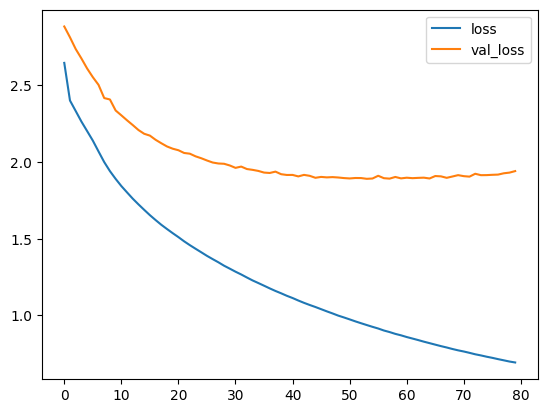

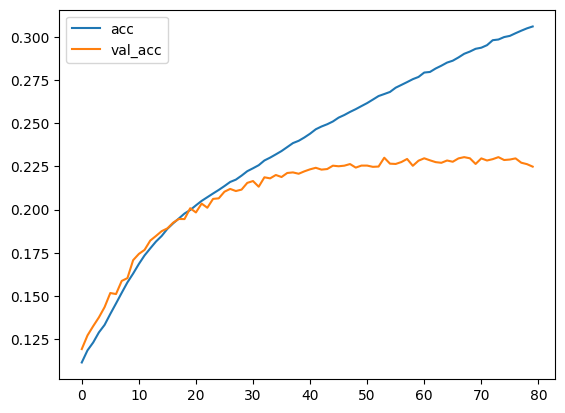

In [22]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [23]:
# Save model
model.save('seq2seq_LSTM.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Make predictions

In [24]:
encoder_inputs_placeholder, encoder_states

(<KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'input_3')>,
 [<KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm')>,
  <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm')>])

In [25]:
##### Make predictions #####
# First, we need to create a model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
encoder_model = Model(encoder_inputs_placeholder, encoder_states)
encoder_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 6)]               0         
                                                                 
 embedding (Embedding)       (None, 6, 100)            249500    
                                                                 
 lstm (LSTM)                 [(None, 256),             365568    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 615068 (2.35 MB)
Trainable params: 615068 (2.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
# DECODER SAMPLING MODEL
decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoder_states_inputs = [decoder_state_input_h] # gru

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# this time, we want to keep the states too, to be output
# by our sampling model
decoder_outputs, h, c = decoder_lstm(
  decoder_inputs_single_x,
  initial_state=decoder_states_inputs
)
# decoder_outputs, state_h = decoder_lstm(
#   decoder_inputs_single_x,
#   initial_state=decoder_states_inputs
# ) #gru
decoder_states = [h, c]
# decoder_states = [h] # gru
decoder_outputs = decoder_dense(decoder_outputs)

# The sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)
decoder_model = Model(
  [decoder_inputs_single] + decoder_states_inputs,
  [decoder_outputs] + decoder_states
)

In [27]:
#word2idx_inputs
word2idx_outputs

{'<eos>': 1,
 '<sos>': 2,
 'es': 3,
 'tom': 4,
 'a': 5,
 'no': 6,
 'me': 7,
 'un': 8,
 'yo': 9,
 'está': 10,
 'él': 11,
 'la': 12,
 'lo': 13,
 'estoy': 14,
 'de': 15,
 'el': 16,
 'se': 17,
 'soy': 18,
 'tom.': 19,
 'en': 20,
 'te': 21,
 'mi': 22,
 'una': 23,
 'que': 24,
 'ella': 25,
 'los': 26,
 'le': 27,
 'tengo': 28,
 'gusta': 29,
 'por': 30,
 '¿quién': 31,
 'las': 32,
 'eso': 33,
 'son': 34,
 'puedo': 35,
 'estaba': 36,
 'esto': 37,
 'esto.': 38,
 'necesito': 39,
 '¿qué': 40,
 'ellos': 41,
 'quiero': 42,
 'muy': 43,
 'tiene': 44,
 'nos': 45,
 '¡qué': 46,
 'estamos': 47,
 'eres': 48,
 'fue': 49,
 'bien.': 50,
 'tu': 51,
 'aquí.': 52,
 '¿es': 53,
 'están': 54,
 'tomás': 55,
 'era': 56,
 'con': 57,
 'voy': 58,
 'eso.': 59,
 'sé': 60,
 'casa.': 61,
 'tom?': 62,
 'estás': 63,
 'tan': 64,
 '¿cómo': 65,
 'he': 66,
 '¿estás': 67,
 'mary.': 68,
 'ahora': 69,
 '¿puedo': 70,
 'al': 71,
 'más': 72,
 'odio': 73,
 'gustan': 74,
 'usted': 75,
 'siento': 76,
 'qué': 77,
 'deja': 78,
 'su': 79,
 'pu

In [28]:
# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [29]:
def decode_sequence(input_seq):
  # Encode the input as state vectors.
  states_value = encoder_model.predict(input_seq, verbose = 0)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))

  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
  eos = word2idx_outputs['<eos>']

  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    output_tokens, h, c = decoder_model.predict(
      [target_seq] + states_value, verbose = 0
    )
    # output_tokens, h = decoder_model.predict(
    #     [target_seq] + states_value
    # ) # gru

    # Get next word
    idx = np.argmax(output_tokens[0, 0, :])

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

    # Update states
    states_value = [h, c]
    # states_value = [h] # gru

  return ' '.join(output_sentence)

In [30]:
while True:
  # Do some test translations
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input:', input_texts[i])
  print('Translation:', translation)

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break

-
Input: Are you ready?
Translation: ¿estás feliz?
Continue? [Y/n]Y
-
Input: I fell for it.
Translation: me engañaron a eso.
Continue? [Y/n]Y
-
Input: Here we are!
Translation: aquí tienes.
Continue? [Y/n]Y
-
Input: I do love you.
Translation: yo sí te te te lo mí.
Continue? [Y/n]Y
-
Input: Don't shout.
Translation: no grites.
Continue? [Y/n]Y
-
Input: Isn't it enough?
Translation: ¿no es suficiente?
Continue? [Y/n]Y
-
Input: Give it to me.
Translation: dámelo.
Continue? [Y/n]Y
-
Input: I love this song.
Translation: me encanta este libro.
Continue? [Y/n]Y
-
Input: I'll miss you.
Translation: te echaré de menos.
Continue? [Y/n]Y
-
Input: I did my part.
Translation: yo hice mi trabajo.
Continue? [Y/n]Y
-
Input: I've found it.
Translation: lo he lo lo lo lo lo lo mí.
Continue? [Y/n]n


The val accuracy is only 22% but as can be seen, 5 out of the 11 test sentences above were correctly translated. It must be noted that due to limited RAM available on Colab, only 10000 samples were selected for training, and only 80 epochs of training were performed. Increasing the training samples and number epochs will definitely help with the accuracy of the model.